# 06. Sentinel-6 MF L2 Altimetry Data Access (OPeNDAP) & Gridding

To-dos:
* Add tutorial objectives, e.g. How much data are we selecting/where? Over a certain Cycle?
* What is the goal of the tutorial? e.g. Grab ___ cycle(s)/pass(es) to plot satellite altimetry tracks from S6 using opendap in the cloud to only select data we are interested in, reducing the data volume and time-to-data.

## Getting Started

### Summary

*Description goes here...*

### Objectives

In this tutorial you will learn...

1. about level 2 radar altimetry data from the Sentinel-6 Michael Freilich mission;
2. how to efficiently download variable subsets using OPeNDAP;
3. how to grid the along-track altimetry observations produced by S6 at level 2.;


### Requirements

This workflow was developed using Python 3.9 (and tested against versions 3.7, 3.8).

In [1]:
import os
import os.path
import json
import warnings
import requests
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
from io import StringIO
from concurrent.futures import ThreadPoolExecutor
warnings.filterwarnings("ignore")
import pyresample as pr
from pyresample.kd_tree import resample_gauss

In [2]:
print("\n# TEMPORARY, CHECK ENVIRONMENT:\n")
for k,v in dict(globals()).items():
    if 'module' in str(type(v)):
        if hasattr(v, "__path__"):
            print(f"  {v.__name__}  \t{v.__version__ }\t({v.__path__[0]})")


# TEMPORARY, CHECK ENVIRONMENT:

  json  	2.0.9	(/srv/conda/envs/notebook/lib/python3.9/json)
  requests  	2.26.0	(/srv/conda/envs/notebook/lib/python3.9/site-packages/requests)
  numpy  	1.21.4	(/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy)
  pandas  	1.3.4	(/srv/conda/envs/notebook/lib/python3.9/site-packages/pandas)
  xarray  	0.20.1	(/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray)
  pyresample  	1.22.0	(/srv/conda/envs/notebook/lib/python3.9/site-packages/pyresample)


### Workspace

Create some directories inside a temporary user workspace. They will be used to write outputs.

In [3]:
workspace = "data/"

for d in ['subsets', 'cycles']:
    os.makedirs(os.path.join(workspace, d), exist_ok=True)

>https://docs.python.org/3/library/os.html#os.makedirs

## Dataset(s)

This example operates on Level 2 Low Resolution Altimetry from Sentinel-6 Michael Freilich (the Near Real Time Reduced distribution). It is most easily identified by its collection *ShortName*, given below:

In [68]:
ShortName = 'JASON_CS_S6A_L2_ALT_LR_RED_OST_NRT_F'


Search CMR using a simple function that wraps `requests.get`:

#### collection

In [69]:
response = requests.get(url=f"https://cmr.earthdata.nasa.gov/search/collections.umm_json", 
                        params=dict(ShortName=ShortName))

print('hits:', response.headers["cmr-hits"])

hits: 1


Get the collection's *concept-id* from the record's `meta` object. It uniquely identifies the collection in the CMR and is a component of the OPeNDAP endpoints for its granules.

In [70]:
collection = response.json().get("items")[0]

concept_id = collection.get("meta").get("concept-id")

print(concept_id)

C1968980576-POCLOUD


>https://docs.python-requests.org/en/latest/api/#requests.get

#### granules

In [71]:
response = requests.get(url=f"https://cmr.earthdata.nasa.gov/search/granules.csv", 
                        params=dict(ShortName=ShortName, page_size=2000))

print('hits:', response.headers["cmr-hits"])

hits: 1849


>https://docs.python.org/3/library/io.html#io.StringIO    
>https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html    
>https://docs.python-requests.org/en/latest/api/#requests.get     

In [72]:
granules = pd.read_csv(StringIO(response.text))

granules.head()

,Granule UR,Producer Granule ID,Start Time,End Time,Online Access URLs,Browse URLs,Cloud Cover,Day/Night,Size
0,S6A_P4_2__LR_RED__NR_022_215_20210622T065556_2...,NaN,2021-06-22T06:55:56.542Z,2021-06-22T08:51:49.469Z,https://archive.podaac.earthdata.nasa.gov/poda...,NaN,NaN,UNSPECIFIED,5.447547
1,S6A_P4_2__LR_RED__NR_022_217_20210622T085149_2...,NaN,2021-06-22T08:51:49.519Z,2021-06-22T10:47:27.453Z,https://archive.podaac.earthdata.nasa.gov/poda...,NaN,NaN,UNSPECIFIED,0.308941
2,S6A_P4_2__LR_RED__NR_022_219_20210622T104727_2...,NaN,2021-06-22T10:47:27.504Z,2021-06-22T12:43:06.457Z,https://archive.podaac.earthdata.nasa.gov/poda...,NaN,NaN,UNSPECIFIED,5.511004
3,S6A_P4_2__LR_RED__NR_022_221_20210622T124306_2...,NaN,2021-06-22T12:43:06.507Z,2021-06-22T14:21:12.461Z,https://archive.podaac.earthdata.nasa.gov/poda...,NaN,NaN,UNSPECIFIED,2.322583
4,S6A_P4_2__LR_RED__NR_022_223_20210622T142112_2...,NaN,2021-06-22T14:21:12.511Z,2021-06-22T16:14:50.491Z,https://archive.podaac.earthdata.nasa.gov/poda...,NaN,NaN,UNSPECIFIED,5.497045


>https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html

Display the list of items created by splitting the a value in the `Granule UR` field.

In [73]:
granules['Granule UR'].iloc[0].split("_")

['S6A',
 'P4',
 '2',
 '',
 'LR',
 'RED',
 '',
 'NR',
 '022',
 '215',
 '20210622T065556',
 '20210622T085149',
 'F02']

References:    
https://docs.python.org/3/library/stdtypes.html#str.split    
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.iloc.html    

*Note that cycle and pass are items 8 and 9, respectively, after splitting the `Granule UR` field by `_`.* Add two columns containing the cycle/pass numbers for granules in the table.

In [51]:
granules = granules[['Granule UR', 'Start Time', 'End Time', 'Online Access URLs']].copy()

granules['cycle'] = granules['Granule UR'].apply(lambda x: x.split("_")[8])

granules['pass'] = granules['Granule UR'].apply(lambda x: x.split("_")[9])

granules.iloc[0]

Granule UR            S6A_P4_2__LR_RED__NR_022_215_20210622T065556_2...
Start Time                                     2021-06-22T06:55:56.542Z
End Time                                       2021-06-22T08:51:49.469Z
Online Access URLs    https://archive.podaac.earthdata.nasa.gov/poda...
cycle                                                               022
pass                                                                215
Name: 0, dtype: object

>https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html    
>https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html    
>https://docs.python.org/3/reference/expressions.html#lambda    
>https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html    

Now create a table with one row per cycle and with these columns:

1. start time
2. end time
3. granule names (list)

In [52]:
tmp = granules.groupby("cycle")

cycles = tmp['pass'].count().to_frame("count")

cycles['start'] = tmp['Start Time'].apply(lambda x: x.tolist()) \
                                   .apply(sorted) \
                                   .apply(lambda x: x[0])  # index 0

cycles['end']   = tmp['End Time'].apply(lambda x: x.tolist()) \
                                 .apply(sorted) \
                                 .apply(lambda x: x[-1])  # index -1

cycles['grans'] = tmp['Granule UR'].apply(lambda x: x.tolist())

display(cycles)

,count,start,end,grans
cycle,,,,
022,20,2021-06-22T06:55:56.542Z,2021-06-23T20:29:40.464Z,[S6A_P4_2__LR_RED__NR_022_215_20210622T065556_...
023,126,2021-06-23T20:29:40.515Z,2021-07-03T18:28:12.477Z,[S6A_P4_2__LR_RED__NR_023_001_20210623T202940_...
024,122,2021-07-03T18:28:12.528Z,2021-07-13T16:26:44.463Z,[S6A_P4_2__LR_RED__NR_024_001_20210703T182812_...
025,125,2021-07-13T16:26:44.514Z,2021-07-23T14:25:14.452Z,[S6A_P4_2__LR_RED__NR_025_001_20210713T162644_...
026,126,2021-07-23T14:25:15.513Z,2021-08-02T12:23:46.465Z,[S6A_P4_2__LR_RED__NR_026_001_20210723T142515_...
027,126,2021-08-02T12:23:46.515Z,2021-08-12T10:22:45.463Z,[S6A_P4_2__LR_RED__NR_027_001_20210802T122346_...
028,125,2021-08-12T10:22:45.514Z,2021-08-22T08:21:16.466Z,[S6A_P4_2__LR_RED__NR_028_001_20210812T102245_...
029,125,2021-08-22T08:21:16.516Z,2021-09-01T06:19:48.489Z,[S6A_P4_2__LR_RED__NR_029_001_20210822T082116_...
030,118,2021-09-01T06:19:48.540Z,2021-09-11T04:18:20.452Z,[S6A_P4_2__LR_RED__NR_030_001_20210901T061948_...


>https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.to_frame.html    
>https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

#### Pick a cycle of interest

Pick one cycle that is nearly complete, >= 120 orbits/files. Limit options to cycles with at least 120 granules/files available (i.e. orbits in S6 context).

In [60]:
cycles = cycles[cycles['count']>=120].copy()

cycles.index.tolist()

['023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '032',
 '033',
 '034',
 '035',
 '036']

Choose from the nearly-complete cycles that remain in the table, which start with cycle number `023` for S6 data in the public domain (and start on June 22). Slice the table of *granules* to exclude all rows that are not from the cycle of interest.

In [80]:
my_cycle = 25

granules = granules[granules.cycle.astype(int)==my_cycle].copy()

granules.index.size

125

In [58]:
granules[10].copy()

KeyError: 0

#### OPeNDAP Access Endpoints

All endpoints for granules/files in OPeNDAP/Hyrax start with the server hostname and path to the parent collection, followed by *granules*. The collection is specified by the *concept-id* given right after *collections* in a valid url. The next cell formats a string giving the base url to which we will append granule filenames (stored in the `Granule UR` column of the *granules* table) to get the full url/endpoint for each granule.

*Fyi, the url printed by this cell will not be accessible from your web browser.*

In [14]:
collection_opendap_endpoint = f"https://opendap.earthdata.nasa.gov/collections/{concept_id}/granules"

print(collection_opendap_endpoint)

https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules


>https://docs.python.org/3/library/string.html#format-string-syntax    

Appending the granule name (taken from the `Granule UR` column) to the end of the url above results in a valid endpoint. You can click the one printed by this cell to confirm. A new browser tab should open to the HTML access form served by Hyrax/OPeNDAP.

Make a new column with the `nc4` download url for all granules.

In [15]:
granules['nc4'] = granules['Granule UR'].apply(lambda x: f"{collection_opendap_endpoint}/{x}.nc4")

granules.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 268 to 392
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Granule UR          125 non-null    object
 1   Start Time          125 non-null    object
 2   End Time            125 non-null    object
 3   Online Access URLs  125 non-null    object
 4   cycle               125 non-null    object
 5   pass                125 non-null    object
 6   nc4                 125 non-null    object
dtypes: object(7)
memory usage: 7.8+ KB


 >https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html    

##### Pick target data/coordinate variables

Display the url to access the DDS file for the first granule:

In [16]:
dds = f"{collection_opendap_endpoint}/{granules['Granule UR'].iloc[0]}.dds"

with requests.get(url=dds) as r:
    print(r.text)

Dataset {
    Int16 data_01_rad_tb_238[data_01_time = 6950];
    Int16 data_01_rad_wet_tropo_cor[data_01_time = 6950];
    Int16 data_01_wind_speed_mod_v[data_01_time = 6950];
    Int32 data_01_rad_distance_to_land[data_01_time = 6950];
    Int16 data_01_rad_tmb_340_qual[data_01_time = 6950];
    Int16 data_01_iono_cor_alt_filtered_mle3[data_01_time = 6950];
    Int16 data_01_rad_tmb_187_qual[data_01_time = 6950];
    Int16 data_01_rad_water_vapor[data_01_time = 6950];
    Int16 data_01_mean_sea_surface_sol1_qual[data_01_time = 6950];
    Int16 data_01_climato_use_flag[data_01_time = 6950];
    Int16 data_01_wind_speed_mod_u[data_01_time = 6950];
    Int16 data_01_distance_to_coast[data_01_time = 6950];
    Int16 data_01_pass_direction_flag[data_01_time = 6950];
    Int32 data_01_altitude_rate_mean_sea_surface[data_01_time = 6950];
    Int16 data_01_mean_sea_surface_sol2_acc[data_01_time = 6950];
    Int16 data_01_model_dry_tropo_cor_measurement_altitude[data_01_time = 6950];
    Int16

>https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.iloc.html    

Assemble the list of target variables that you will subset from each granule/file using OPeNDAP.

In [17]:
variables = ['data_01_time',
             'data_01_longitude',
             'data_01_latitude',
             'data_01_ku_ssha', ]

>https://docs.python.org/3/library/stdtypes.html#list    

Join the list of variables with commas and append the resulting string to the end of each opendap `nc4` endpoint created during the steps above. The variables given after the `?` will be subset from the source file on the server-side into a new netCDF4 file that OPeNDAP returns in response content which is downloaded over https.

Here's an example for the first granule in the selected cycle. Clicking this link should download a netCDF4 containing the target variables (4 of them, in my case). *You may be prompted to authenticate with your Earthdata Login account info.

In [18]:
granules['subset'] = granules['nc4'].apply(lambda url: f"{url}?{','.join(variables)}")

print(granules['subset'].iloc[0])

https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_001_20210713T162644_20210713T182234_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha


>https://opendap.github.io/documentation/UserGuideComprehensive.html#Constraint_Expressions (Hyrax/OPeNDAP docs)    

#### Download subsets

This function downloads one granule from the remote `url` to a local `target` path, and will reliably manage simultaneous streaming downloads divided between multiple threads.

In [19]:
def download(url: str, target: str, force: bool=False):
    if not os.path.isfile(target) or force is True:
        with requests.get(url) as response, open(target, 'wb') as file:
            if not response.status_code // 100 == 2: 
                raise Exception(response.text)
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
    return target

>https://docs.python.org/3/library/os.path.html#os.path.isfile    
>https://docs.python-requests.org/en/latest/api/#requests.Response.text    
>https://docs.python-requests.org/en/latest/api/#requests.Response.status_code    
>https://docs.python-requests.org/en/latest/api/#requests.Response.iter_content    

In [20]:
#!ls data/subsets/*NR_025*.nc4 | wc -l
#!rm data/subsets/*NR_025*.nc4

*This next cell assembles a list of local paths for the subset downloads.*

Calling `tolist` on the resulting Series will convert it to a Python list (by way of the *numpy* method, *tolist*). Use *zip* merge the lists of *subset* urls and local paths, itemwise. The result will be a list of lists, each length two and containing a remote url and local path (corresponding to two positional arguments in the *download* function that will be defined in a subsequent cell).

In [21]:
download_targets = granules['Granule UR'].apply(lambda x: f"data/subsets/{x}.nc4")

download_arguments = list(zip(granules['subset'].tolist(), download_targets.tolist()))

type(download_arguments), len(download_arguments)

(list, 125)

>https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.tolist.html    

*This next cell creates a pool of workers to divide the list of downloads between multiple threads.*

Use the `ThreadPoolExecutor` from `concurrent.futures` module (in the Python 3 standard library) to divide the 120+ download jobs between multiple threads and run them concurrently. This should take no more than a minute or two to process all subsets on the server side and download to the local host.

In [22]:
with ThreadPoolExecutor(max_workers=12) as pool:
    
    workers = pool.map(lambda x: download(*x), download_arguments)
    
    granules['local'] = list(tqdm(workers, total=len(download_arguments)))

100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


>https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor    

The source files range from 2.5MB to 3.0MB. These OPeNDAP subsets are ~100KB apiece. (anecdote: it took less than 10 minutes to download subsets for >1700 granules/files when I ran this routine for all cycles going back to 2021-06-22.) Here we call the shell *du* and *ls* utilities to get the size of the directory:

In [23]:
%%bash

du -sh data/subsets/

ls data/subsets/*.nc4 | wc -l

14M	data/subsets/
125


>https://www.gnu.org/software/coreutils/manual/html_node/du-invocation.html    

Confirm that a netcdf file exists on disk for all the file paths in the *local* column.

In [24]:
granules['local'].apply(os.path.isfile).all()

True

>https://docs.python.org/3/library/functions.html#sorted    
>https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.all.html    

#### Aggregate to cycle

Make a dictionary to rename variables so that the `data_01_` prefix is removed from each one.

In [25]:
new_variable_names = list(map(lambda x: x.split("_")[-1], variables))

map_variable_names = dict(zip(variables, new_variable_names))

map_variable_names

{'data_01_time': 'time',
 'data_01_longitude': 'longitude',
 'data_01_latitude': 'latitude',
 'data_01_ku_ssha': 'ssha'}

References:    
https://docs.python.org/3/library/functions.html#map    
https://docs.python.org/3/library/functions.html#zip    

Sort the list of local paths to the downloaded subsets to ensure they concatenate in proper order. Call `open_mfdataset` on the list to open all the subsets in memory as one dataset in xarray.

In [26]:
local = sorted(granules['local'].tolist())

dataset = xr.open_mfdataset(local).rename(map_variable_names)

print(dataset)

<xarray.Dataset>
Dimensions:    (time: 827001)
Coordinates:
  * time       (time) datetime64[ns] 2021-07-13T16:26:45 ... 2021-07-23T14:25:14
Data variables:
    longitude  (time) float64 dask.array<chunksize=(6950,), meta=np.ndarray>
    latitude   (time) float64 dask.array<chunksize=(6950,), meta=np.ndarray>
    ssha       (time) float64 dask.array<chunksize=(6950,), meta=np.ndarray>
Attributes: (12/63)
    Convention:                             CF-1.7
    institution:                            EUMETSAT
    references:                             Sentinel-6_Jason-CS ALT Generic P...
    contact:                                ops@eumetsat.int
    radiometer_sensor_name:                 AMR-C
    doris_sensor_name:                      DORIS
    ...                                     ...
    xref_solid_earth_tide:                  S6__P4_2__SETD_AX_20151008T000000...
    xref_surface_classification:            S6__P4____SURF_AX_20151008T000000...
    xref_wind_speed_alt:            

>https://tqdm.github.io/docs/tqdm/#pandas    
>https://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html    
>https://xarray.pydata.org/en/stable/generated/xarray.Dataset.rename.html  

### Render along-track altimetry data to the ECCO grid 

>**Acknowledgement** *This approach using `pyresample` was shared to me by Ian Fenty, ECCO Lead.*

ECCO V4r4 products are distributed in two spatial formats. One set of collections provides the ocean state estimates on the native model grid (LLC0090) and the other provides them after interpolating to a regular grid defined in geographic coordinates with horizontal cell size of 0.5-degrees.

#### Download the ECCO V4r4 0.5-Deg Grid Geometry and Mask

It's distributed as its own dataset/collection containing just one file. We can access it over OPeNDAP like demonstrated above or simply download it from the HTTPS download endpoint -- the file size is inconsequential. The next cell downloads the file into the *data* folder from the granule's https endpoint.

In [27]:
ecco_url = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_GEOMETRY_05DEG_V4R4/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc"

ecco_file = download(ecco_url, target=f"data/{os.path.basename(ecco_url)}")

ecco_grid = xr.open_dataset(ecco_file)

print(ecco_grid)

<xarray.Dataset>
Dimensions:         (Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...
    Z_bnds          (Z, nv) float32 ...
Dimensions without coordinates: nv
Data variables:
    hFacC           (Z, latitude, longitude) float64 ...
    Depth           (latitude, longitude) float64 ...
    area            (latitude, longitude) float64 ...
    drF             (Z) float32 ...
    maskC           (Z, latitude, longitude) bool ...
Attributes: (12/57)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                     

>https://docs.python.org/3/library/os.path.html#os.path.basename    
>https://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html    

The `maskC` variable contains a boolean mask representing the wet/dry state of the area contained in each cell of the 3d grid defined by `Z` and `latitude` and `longitude`.

Here are the variable's attributes:

In [28]:
ecco_grid.maskC.attrs

{'coverage_content_type': 'modelResult',
 'long_name': 'wet/dry boolean mask for grid cell',
 'comment': 'True for grid cells with nonzero open vertical fraction (hFacC > 0), otherwise False.'}

So, the mask derives from another variable `hFacC` that essentially describes 3d space/volume contained within each model grid cell by the fractional area representing the horizontal coverage (in the `longitude,latitude` dimensions) within each vertical/depth layer.

In [29]:
ecco_grid.hFacC.attrs

{'coverage_content_type': 'modelResult',
 'long_name': 'vertical open fraction of grid cell',
 'units': '1',
 'comment': 'Grid cells may be fractionally closed in the vertical. The open vertical fraction is hFacC. The model allows for partially-filled cells to represent topographic variations more smoothly (hFacC < 1). Completely closed (dry) tracer grid cells have hFacC = 0. Note: the lat-lon gridded hFacC is spatially-averaged from the hFacC field on the lat-lon-cap (llc90) model native grid. The total ocean volume of the ECCO V4r4 lat-lon gridded fields is within 0.05% of the total ocean volume of the native grid fields.'}

Select the 2d array from `maskC` that corresponds to the depth layer at ocean surface (i.e. at index `0` on the `Z` axis/dimension) and then produce a boolean array where True represents cells with a value greater than `0`. The resulting array/grid is our land/water mask for the 2d grids generated during the next few steps.

Plot the land/water mask:

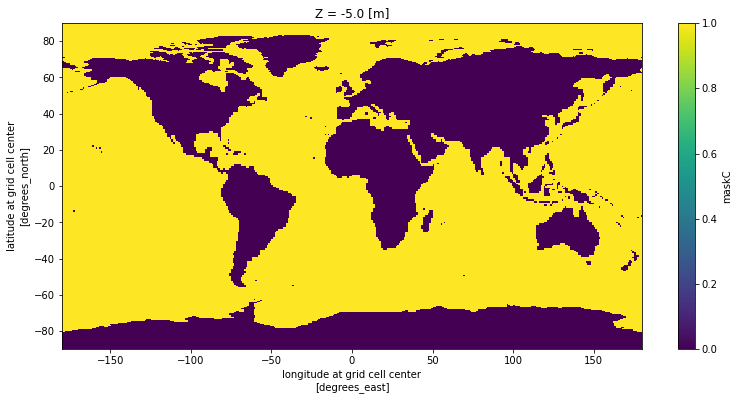

In [30]:
ecco_mask = ecco_grid.maskC.isel(Z=0)>0

ecco_mask.plot(figsize=(13, 6))

>https://xarray.pydata.org/en/stable/generated/xarray.DataArray.isel.html    
>https://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html    

### Grid ssha or a similar variable

*Jinbo's recommendation: wrap this logic for parameterization by workshop attendees.*

Get a single timestamp to represent the midpoint of the cycle.

In [31]:
time = np.datetime64(dataset['time'].mean().data)

print(time)

2021-07-18T15:11:35.073955170


Access the target variable, *ssha* in this case, and make a nan mask.

In [32]:
ssha = dataset.ssha

nans = ~np.isnan(ssha.values)

print(ssha)

<xarray.DataArray 'ssha' (time: 827001)>
dask.array<concatenate, shape=(827001,), dtype=float64, chunksize=(6981,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-07-13T16:26:45 ... 2021-07-23T14:25:14
Attributes:
    long_name:      sea surface height anomaly
    standard_name:  sea_surface_height_above_sea_level
    units:          m
    comment:        Sea surface height anomaly = altitude of satellite (altit...
    coordinates:    /data_01/longitude /data_01/latitude
    origname:       ssha
    fullnamepath:   /data_01/ku/ssha


Define a simple function *get_grid_defn* to validate input arrays of longitudes/latitudes and return a *pyresample.geometry.SwathDefinition* object. (We use it twice to define source/target grids in the next steps.)

In [33]:
def get_grid_defn(lons: np.ndarray, lats: np.ndarray):
    
    if lats.min() <  -90. or lats.max() > 90.:  #1
        raise ValueError('Found invalid latitudes, aborting - see if condition 1\n')
    
    if lons.min() < -180. or lons.max() >= 180.:  #2
        print('Found invalid longitudes, wrapping - see if condition 2\n')
        lons = (lons + 180) % 360 - 180
    
    return pr.SwathDefinition(lons, lats)

Define source grid/geometry for the input along-track data. (They are stored as 1-dimensional arrays.)

In [34]:
lons = dataset.longitude.values
lats = dataset.latitude.values

alt_grid_defn = get_grid_defn(lons[nans], lats[nans])

type(alt_grid_defn)

Found invalid longitudes, wrapping - see if condition 2



pyresample.geometry.SwathDefinition

Define target grid based on the longitudes and latitudes from the ECCO grid geometry dataset. This time define the grid using two 2-dimensional arrays that give positions of all SSHA values in geographic/longitude-latitude coordinates.

In [35]:
ecco_lons = ecco_grid.longitude.values
ecco_lats = ecco_grid.latitude.values

ecco_lons_2d, ecco_lats_2d = np.meshgrid(ecco_lons, ecco_lats)

print(ecco_lons_2d.shape, ecco_lats_2d.shape)

(360, 720) (360, 720)


Make the *pyresample* object for the target grid and proceed.

In [36]:
ecco_grid_defn = get_grid_defn(ecco_lons_2d, ecco_lats_2d)

Show the help for `pyresample.kdtree.resample_gauss` to aid during the hackathon.

In [37]:
#help(resample_gauss)

Get the target grid definition defined by the 2d arrays of lons and lats created in the cell above. Apply gaussian resampling with some optional arguments (borrowed from Ian's implementation).

In [38]:
result, stddev, counts = resample_gauss(
    alt_grid_defn,      # source grid
    ssha.values[nans],  # source data
    ecco_grid_defn,     # target grid
    radius_of_influence = 1.75e5,  
    sigmas              = 25000,
    fill_value          = np.nan, 
    neighbours          = 100, 
    with_uncert         = True,
)

type(result), type(stddev), type(counts)

(numpy.ndarray, numpy.ma.core.MaskedArray, numpy.ndarray)

Apply the land/water mask in the numpy array created from the ECCO layer in the steps above. Then, convert the masked numpy array to an xarray data array object named *gridded*. Print its header.

In [39]:
masked = np.where(ecco_mask, result, np.nan)

gridded = xr.DataArray(masked, 
                       name="ssha",
                       dims=['latitude', 'longitude'], 
                       coords={'time': time, 'longitude': ecco_lons, 'latitude': ecco_lats})

print(gridded)

<xarray.DataArray 'ssha' (latitude: 360, longitude: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time       datetime64[ns] 2021-07-18T15:11:35.073955170
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75


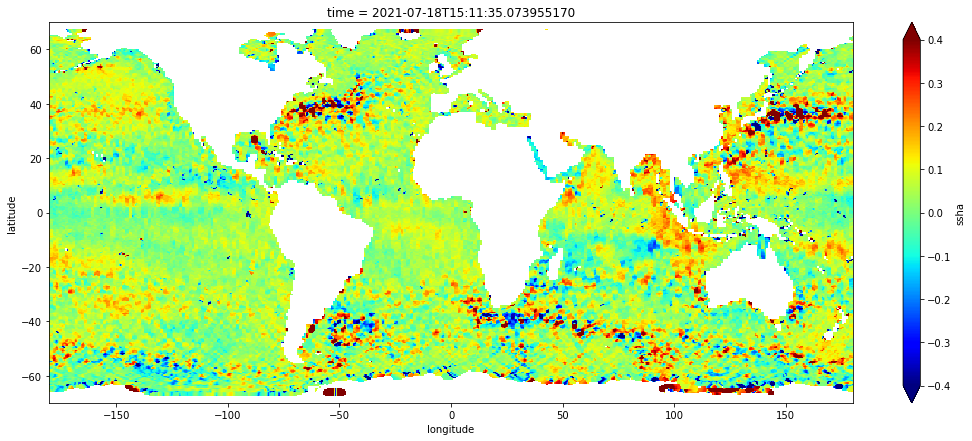

In [40]:
gridded.sel(latitude=slice(-70.0, 70.0)).plot.pcolormesh(vmin=-0.4, vmax=0.4, cmap="jet", figsize=(18,7))

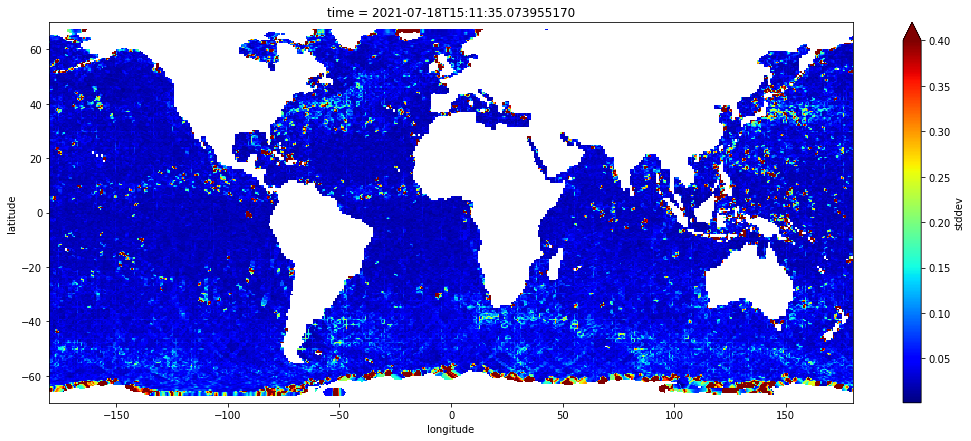

In [41]:
stddev = xr.DataArray(np.where(ecco_mask, stddev, np.nan), 
                      name="stddev",
                      dims=['latitude', 'longitude'], 
                      coords={'time': time, 'longitude': ecco_lons, 'latitude': ecco_lats})

stddev.sel(latitude=slice(-70.0, 70.0)).plot.pcolormesh(vmax=0.4, cmap="jet", figsize=(18, 7))

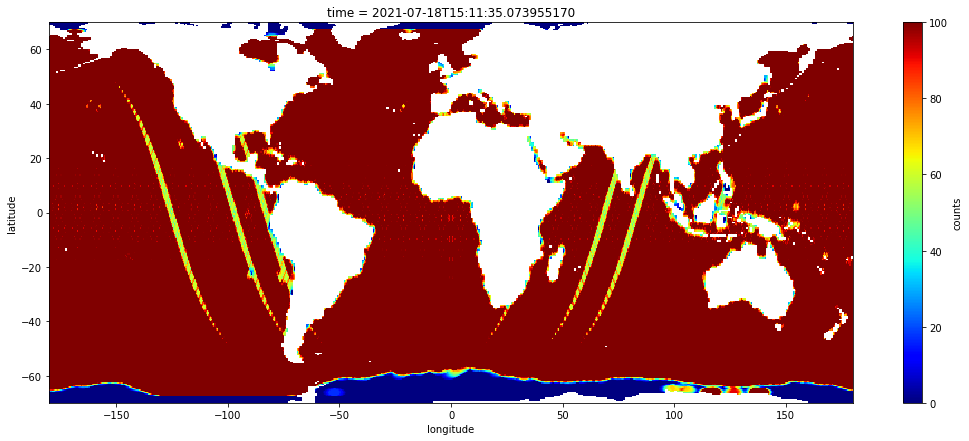

In [42]:
counts = xr.DataArray(np.where(ecco_mask, counts, np.nan), 
                      name="counts",
                      dims=['latitude', 'longitude'], 
                      coords={'time': time, 'longitude': ecco_lons, 'latitude': ecco_lats})

counts.sel(latitude=slice(-70.0, 70.0)).plot.pcolormesh(cmap="jet", figsize=(18, 7))

**Additional References:**

* *numpy* (https://numpy.org/doc/stable/reference)    
    * [numpy.ndarray.data](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.data.html)    
    * [numpy.ravel](https://numpy.org/doc/stable/reference/generated/numpy.ravel.html)    
    * [numpy.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html)    
    * [numpy.isnan](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html)    
    * [datetimes](https://numpy.org/doc/stable/reference/arrays.datetime.html)    
* *xarray* (https://xarray.pydata.org/en/stable)    
    * [xarray.DataArray](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html)    
    * [xarray.DataArray.values](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.values.html)    
    * [xarray.DataArray.mean](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html)    
    * https://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.pcolormesh.html (matplotlib)    
* *pyresample* (https://pyresample.readthedocs.io/en/latest/api/pyresample)    
    * [pyresample.utils.check_and_wrap](https://pyresample.readthedocs.io/en/latest/api/pyresample.utils.html#pyresample.utils.check_and_wrap)    
    * [pyresample.kd_tree.resample_gauss](https://pyresample.readthedocs.io/en/latest/api/pyresample.html#pyresample.kd_tree.resample_gauss)    
    * [pyresample.geometry.SwathDefinition](https://pyresample.readthedocs.io/en/latest/api/pyresample.html#pyresample.geometry.SwathDefinition)    


**Bonus**: generate a grid for every cycle and get mean/std over all the cycles

```python
stack = xr.concat(data['grid'].tolist(), dim="time")

midlat = stack.sel(latitude=slice(-66.,66.0))

stats = xr.concat(objs=[midlat.mean("time"),
                        midlat.std("time") ], 
                  dim=pd.Index(['mean','std'], name="stat"))
```

>https://xarray.pydata.org/en/stable/generated/xarray.concat.html    

**Bonus**: calculate area-weighted mean

```python
def to_area_weighted_mean(x):
    nonzero_mask = np.where(~np.isnan(x), 1, np.nan)            # mask where nans=0 & ~nans=1
    nonzero_area = np.sum(nonzero_mask * ecco_grid.area)        # total area where data is nonzero
    return float(np.nansum(x * ecco_grid.area) / nonzero_area)  # area-weighted global mean
```

>https://numpy.org/doc/stable/reference/generated/numpy.sum.html    
>https://numpy.org/doc/stable/reference/generated/numpy.nansum.html    